In [1]:
# import os
# %pip install tensorflow
# %pip install statsmodels
# %pip install numpy
# %pip install tensorflow
# %pip install pandas
# %pip install matplotlib
# %pip install sklearn.preprocessing
# %pip install seaborn

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


DONE


In [2]:
df = pd.read_csv("./btcpricesfinal2022.csv",parse_dates=['Date'])
cols = [0]
df.drop(df.columns[cols],axis=1,inplace=True)

In [3]:
df.head(10)

,Date,Closing Price (USD)
0,2013-10-01,123.65499
1,2013-10-02,125.45500
2,2013-10-03,108.58483
3,2013-10-04,118.67466
4,2013-10-05,121.33866
5,2013-10-06,120.65533
6,2013-10-07,121.79500
7,2013-10-08,123.03300
8,2013-10-09,124.04900
9,2013-10-10,125.96116


Text(0, 0.5, 'Close Price (USD)')

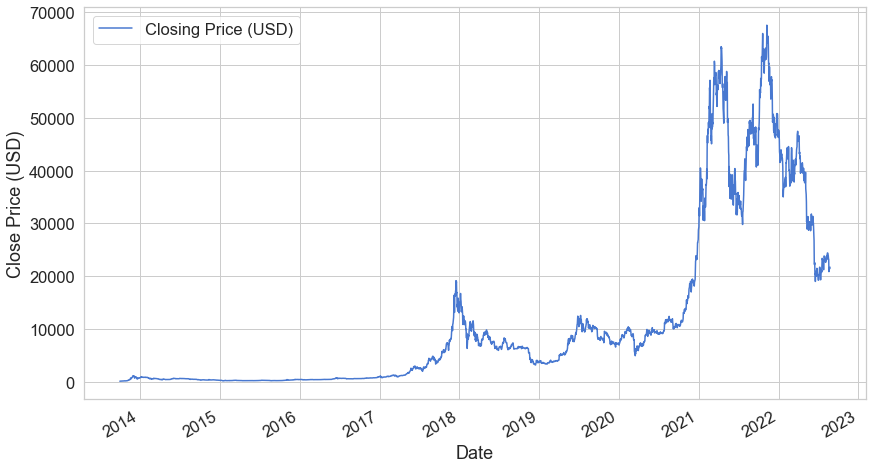

In [4]:
ax = df.plot(x='Date', y='Closing Price (USD)');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [5]:
df = df.rename(columns = {'Date' : 'Date', 'Closing Price (USD)' : 'Close'})


scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [6]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [7]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.7)

In [8]:
X_test.shape

(936, 99, 1)

In [9]:
X_train.shape

(2181, 99, 1)

In [10]:
shape0 = SEQ_LEN -1
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(shape0,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 99, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 99, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [12]:
BATCH_SIZE = 25

history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/20
79/79 [==============================] - 7s 45ms/step - loss: 4.6812e-04 - val_loss: 0.0045
Epoch 2/20
79/79 [==============================] - 3s 36ms/step - loss: 0.0014 - val_loss: 0.0059
Epoch 3/20
79/79 [==============================] - 3s 36ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 4/20
79/79 [==============================] - 3s 36ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/20
79/79 [==============================] - 3s 35ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 6/20
79/79 [==============================] - 3s 35ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/20
79/79 [==============================] - 3s 35ms/step - loss: 0.0020 - val_loss: 9.3471e-04
Epoch 8/20
79/79 [==============================] - 3s 35ms/step - loss: 0.0019 - val_loss: 6.5801e-04
Epoch 9/20
79/79 [==============================] - 3s 35ms/step - loss: 0.0015 - val_loss: 5.2673e-04
Epoch 10/20
79/79 [==============================] - 3s 35ms/step - loss: 0.0013 - val_loss: 

In [13]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 11ms/step - loss: 0.0066


0.006615302991122007

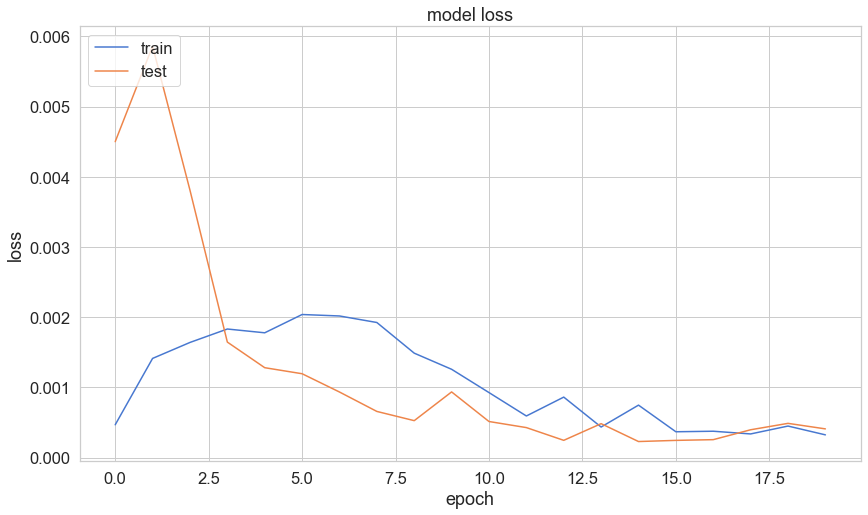

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

30/30 [==============================] - 1s 10ms/step


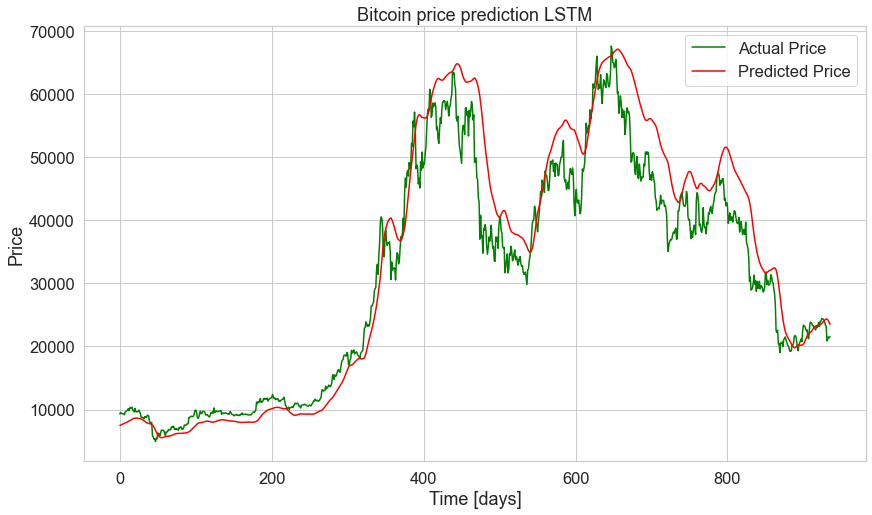

In [15]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')


plt.title('Bitcoin price prediction LSTM')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [16]:
#index = tf.argmax(y_hat).numpy()[0]

---------------------Result----------------------------
    Equity: 359047.30
    Return: 259.05%
          
Date   |   Money   |   Equity   |  Total Return | Share |  Action
   1      4549.22    100000.00       100.00%       10    BUY
  22    100864.07    100864.07       100.86%        0    SELL
  56       259.29    100864.07       100.86%       15    BUY
  78    107758.04    107758.04       107.76%        0    SELL
  80      5878.07    107758.04       107.76%       14    BUY
 116    132560.08    132560.08       132.56%        0    SELL
 123       572.70    132560.08       132.56%       14    BUY
 136    132993.93    132993.93       132.99%        0    SELL
 162      3687.93    132993.93       132.99%       14    BUY
 170    131933.68    131933.68       131.93%        0    SELL
 175      8033.40    131933.68       131.93%       13    BUY
 208    160705.56    160705.56       160.71%        0    SELL
 217       717.72    160705.56       160.71%       14    BUY
 219    148612.28    14861

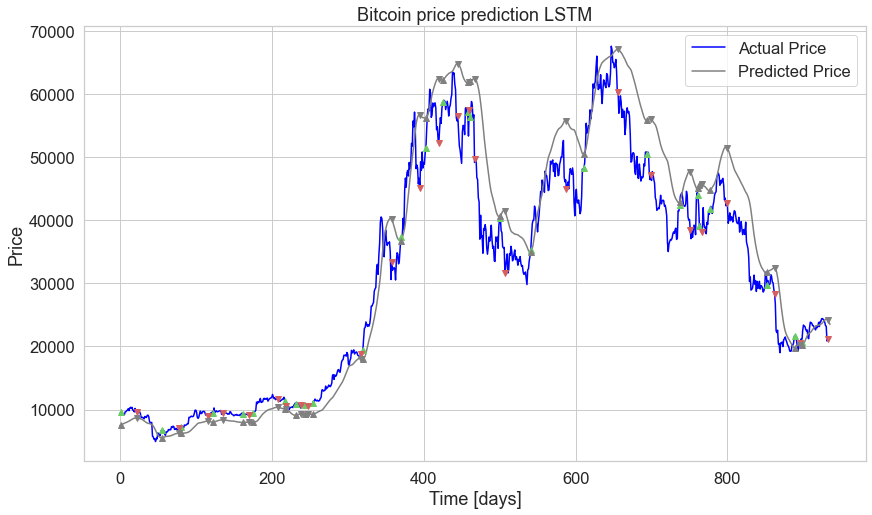

In [17]:
def trend(data,i):
    return data[i] - data[i-1]

def simple_trade(data, real_price, money = 100000):
    start_money = money
    equity = money
    share = 0
    trade_record = []
    trade_record.append("Date   |   Money   |   Equity   |  Total Return | Share |  Action")
    
    # Plot
    buy_record = []
    sell_record = []
    
    for i in range(1,len(data)):        
        if trend(data, i) > 0 and money - real_price[i] > 0:  # BUY SIGNAL
            share += money // real_price[i]
            money -= (money // real_price[i]) * real_price[i]
            equity = money + share * real_price[i]
            trade_record.append("{0:>4} {1:>12.2f} {2:>12.2f} {3:>12.2f}% {4:>8.0f}    BUY".format(i,money[0],equity[0],equity[0]/start_money* 100 ,share[0]))
            buy_record.append(i)
        elif trend(data, i) < 0 and share > 0: 
            money += real_price[i] * share
            share = 0
            equity = money
            trade_record.append("{0:>4} {1:>12.2f} {2:>12.2f} {3:>12.2f}% {4:>8.0f}    SELL".format(i,money[0],equity[0],equity[0]/start_money* 100,share))
            sell_record.append(i)
        
    # REPORT
    print("---------------------Result----------------------------\n\
    Equity: {0:.2f}\n\
    Return: {1:.2f}%\n\
          ".format(equity[0], (equity / start_money * 100 -100)[0] ))
    for record in trade_record:
        print(record)
    
    plt.plot(y_test_inverse, label="Actual Price", color='blue')
    plt.plot(y_hat_inverse, label="Predicted Price", color='gray')
    for day in buy_record:
        plt.plot(day, real_price[day], "^", color = "g")
        plt.plot(day, data[day], "^", color = "gray")
    for day in sell_record:
        plt.plot(day, real_price[day], "v", color = "r")
        plt.plot(day, data[day], "v", color = "gray")
    
    plt.title('Bitcoin price prediction LSTM')
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')
    
    plt.show();

simple_trade(y_hat_inverse,y_test_inverse)

#simple_trade_gradual(y_hat_inverse,y_test_inverse)

---------------------Result----------------------------
    Equity: 236530.50
    Return: 136.53%
          
Date   |   Money   |   Equity   |  Total Return |  Action
   1     90454.92    100000.00       100.00%        1    BUY
   2     81066.04     99843.80        99.84%        2    BUY
   3     71702.85     99792.43        99.79%        3    BUY
   4     62317.59     99858.63        99.86%        4    BUY
   5     53047.88     99396.42        99.40%        5    BUY
   6     43869.99     98937.35        98.94%        6    BUY
   7     34244.53    101622.73       101.62%        7    BUY
   8     24563.15    102014.17       102.01%        8    BUY
   9     14767.81    102925.90       102.93%        9    BUY
  10      4840.03    104117.81       104.12%       10    BUY
  22     14471.51    101154.88       101.15%        9    SELL
  23     24142.37    101509.24       101.51%        8    SELL
  24     33831.46    101655.07       101.66%        7    SELL
  25     43751.01    103268.32       

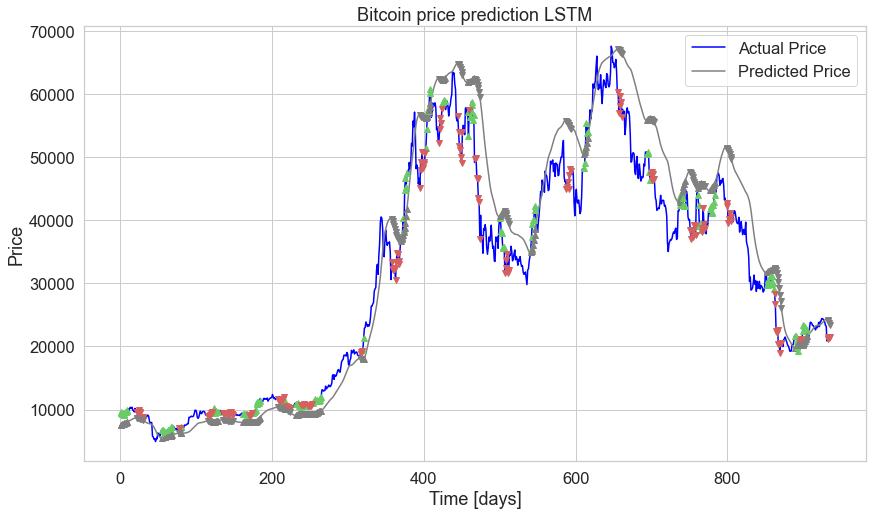

In [18]:
def simple_trade_gradual(data, real_price, money = 100000):
    start_money = money
    equity = money
    share = 0
    trade_record = []
    trade_record.append("Date   |   Money   |   Equity   |  Total Return |  Action")
    
    # Plot
    buy_record = []
    sell_record = []
    
    for i in range(1,len(data)):        
        if data[i] - data[i-1] > 0 and money - real_price[i] > 0:  # BUY SIGNAL
            share += 1
            money -= real_price[i]
            equity = money + share * real_price[i]
            trade_record.append("{0:>4} {1:>12.2f} {2:>12.2f} {3:>12.2f}% {4:>8.0f}    BUY".format(i,money[0],equity[0],equity[0]/start_money* 100 ,share))
            buy_record.append(i)
        elif data[i] - data[i-1] < 0 and share > 0: 
            money += real_price[i] * 1
            share -= 1
            equity = money + share * real_price[i]
            trade_record.append("{0:>4} {1:>12.2f} {2:>12.2f} {3:>12.2f}% {4:>8.0f}    SELL".format(i,money[0],equity[0],equity[0]/start_money* 100,share))
            sell_record.append(i)
    
    # REPORT
    print("---------------------Result----------------------------\n\
    Equity: {0:.2f}\n\
    Return: {1:.2f}%\n\
          ".format(equity[0], (equity / start_money * 100 -100)[0] ))
    for record in trade_record:
        print(record)
    
    plt.plot(y_test_inverse, label="Actual Price", color='blue')
    plt.plot(y_hat_inverse, label="Predicted Price", color='gray')
    for day in buy_record:
        plt.plot(day, real_price[day], "^", color = "g")
        plt.plot(day, data[day], "^", color = "gray")
    for day in sell_record:
        plt.plot(day, real_price[day], "v", color = "r")
        plt.plot(day, data[day], "v", color = "gray")
    
    plt.title('Bitcoin price prediction LSTM')
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')
    
    plt.show();
simple_trade_gradual(y_hat_inverse,y_test_inverse)

---------------------Result----------------------------
    Equity: 408108.83
    Return: 308.11%
          
Date   |   Money   |   Equity   |  Total Return | Share |  Action
  90      6858.89    100000.00       100.00%       12    BUY
 221    129350.15    129350.15       129.35%        0    SELL
 256      4675.86    129350.15       129.35%       11    BUY
 453    607747.59    607747.59       607.75%        0    SELL
 547     24980.86    607747.59       607.75%       14    BUY
 601    653512.23    653512.23       653.51%        0    SELL
 619     21179.55    653512.23       653.51%       11    BUY
 665    610446.97    610446.97       610.45%        0    SELL
 785     31936.20    610446.97       610.45%       13    BUY
 831    408108.83    408108.83       408.11%        0    SELL
 904      3730.21    408108.83       408.11%       18    BUY


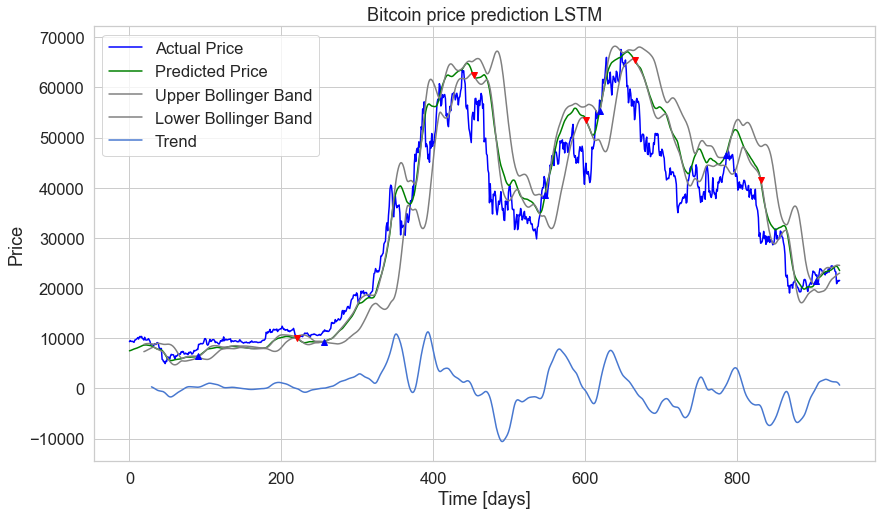

In [22]:
def sma(data, window):
    df = pd.DataFrame(data)
    return df.rolling(window = window).mean()

def bollingerBands(data,sma,window):
    df = pd.DataFrame(data)
    std = df.rolling(window= window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb.to_numpy(), lower_bb.to_numpy()



def bollingerBandTrade(predictedData, real_price, money = 100000):
    sma_20 = sma(predictedData, 20)
    ubb, lbb = bollingerBands(predictedData, sma_20, 20)
    trend = (sma(predictedData, 5) - sma(predictedData, 30)).to_numpy()
    buy_record = []
    sell_record = []
    trade_record = []
    trade_record.append("Date   |   Money   |   Equity   |  Total Return | Share |  Action")
    
    start_money = money
    equity = money 
    share = 0
    
    for i in range(31, len(predictedData)):
        if trend[i] > 0:
            if predictedData[i] - ubb[i] >= 0 and money > real_price[i]:
                share += money // real_price[i]
                money -= (money // real_price[i]) * real_price[i]
                equity = money + share * real_price[i]
                trade_record.append("{0:>4} {1:>12.2f} {2:>12.2f} {3:>12.2f}% {4:>8.0f}    BUY".format(i,money[0],equity[0],equity[0]/start_money* 100 ,share[0]))
                buy_record.append(i)
        
        else:
            if predictedData[i] - lbb[i] <= 0 and share > 0:
                money += real_price[i] * share
                share = 0
                equity = money
                trade_record.append("{0:>4} {1:>12.2f} {2:>12.2f} {3:>12.2f}% {4:>8.0f}    SELL".format(i,money[0],equity[0],equity[0]/start_money* 100,share))
                sell_record.append(i)
    
    print("---------------------Result----------------------------\n\
    Equity: {0:.2f}\n\
    Return: {1:.2f}%\n\
          ".format(equity[0], (equity / start_money * 100 -100)[0] ))
    for record in trade_record:
        print(record)
        
    # PLOT
    plt.plot(y_test_inverse, label="Actual Price", color='blue')
    plt.plot(y_hat_inverse, label="Predicted Price", color='green')
    plt.plot(ubb, label = "Upper Bollinger Band", color = 'gray')
    plt.plot(lbb, label = "Lower Bollinger Band", color = 'gray')
    plt.plot(trend, label = "Trend")
    for d in buy_record:
        plt.plot(d,y_hat_inverse[d] ,"^" ,color = "blue")
    for d in sell_record:
        plt.plot(d,y_hat_inverse[d] ,"v" ,color = "red")
    plt.title('Bitcoin price prediction LSTM')
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')
    
bollingerBandTrade(y_hat_inverse, y_test_inverse)